# UN Analysis

Analysis of UN actors in agreement-actor networks.


In [1]:
__author__      = 'Roy Gardner'

%run ./network_functions.py


## Load the agreement-actor data

- Load data into a binary-valued relation matrix (BVRM) with agreements in rows and actors in columns
- Matrix values are zero except where a relation between an agreement and an actor exists where the value is one
- Apart from the matrix other data are extracted or computed
- All data are stored in data_dict


In [2]:

data_path = './data/'
nodes_file = 'node_table.csv'
links_file = 'links_table.csv'
agreements_dict = 'agreements_dict.json'

data_dict = load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path)
print(data_dict.keys())


dict_keys(['agreements_dict', 'dates_dict', 'nodes_data', 'nodes_header', 'links_data', 'links_header', 'agreement_vertices', 'actor_vertices', 'vertices_dict', 'color_map', 'matrix'])


In [3]:
print(len(data_dict['agreement_vertices']))
print(len(data_dict['actor_vertices']))

#print(data_dict['vertices_dict']['IGO_49'])


1642
1096


## Collect UN actor indices and IDs

In [4]:

un_actors_list = []

for actor_index,actor_id in enumerate(data_dict['actor_vertices']):
    if len(actor_id) == 0:
        continue
    if not actor_id.startswith('IGO_') and not actor_id.startswith('COA_'):
        continue
    actor_data = data_dict['vertices_dict'][actor_id]
    actor_name = actor_data[data_dict['nodes_header'].index('node_name')]
    if 'United Nations' in actor_name or actor_name.startswith('UN') or ' UN' in actor_name:
        un_actors_list.append((actor_index,actor_id,actor_name))

un_actors_list = sorted(un_actors_list,key=lambda t:t[2])

# Print ready for insertion in LaTex document
latex = False
if latex:
    for t in un_actors_list:
        s = t[2] + ' & ' + '\\_'.join(t[1].split('_')) + ' \\\\'
        print(s)
        print('\\hline')
    

## Get UN actor biadjacency matrices

There are two matrices:

1. UN-only matrix: 
    - Rows are agreements that have at least one UN signatory
    - Columns are UN actors
2. UN actors and non-UN co-signatories matrix:
    - Rows are agreements that have at least one UN signatory (as above)
    - Columns are all the actors who are signatories to the row agreements

The indices of the agreements and actors that constitute the above matrices are:

- agreement_indices: Indices into `data_dict['agreement_vertices']` and therefore rows of `data_dict['matrix']`
- un_indices: Indices into `data_dict['actor_vertices']` and therefore columns of `data_dict['matrix']` for UN actors only
- actor_indices: Indices into `data_dict['actor_vertices']` and therefore columns of `data_dict['matrix']` for UN actors and co-signatories


In [5]:
un_indices = [t[0] for t in un_actors_list]

matrix = data_dict['matrix']

# Reduce the matrix to UN actor columns only
reduced_matrix = matrix[np.ix_(range(0,matrix.shape[0]),un_indices)]
# Get indices of agreement row containing at least one non-zero value, i.e., agreements signed by at least
# one of the UN actors
indices = np.nonzero(reduced_matrix)
agreement_indices = list(set(indices[0]))

# This is the UN actors only matrix
un_matrix = matrix[np.ix_(agreement_indices,un_indices)]
print(un_matrix.shape)

# Reduce the complete matrix to the UN agreement rows and all actors
reduced_matrix = matrix[np.ix_(agreement_indices,range(0,matrix.shape[1]))]

# Get indices of all non-zero actor columns for the agreement rows, i.e., UN actors and co-signatories
indices = np.nonzero(reduced_matrix)
actor_indices = list(set(indices[1]))

# This is the UN actors and non-UN co-signatories matrix
un_cosign_matrix = matrix[np.ix_(agreement_indices,actor_indices)]
print(un_cosign_matrix.shape)
print()

print('There are',un_matrix.shape[0],'agreements signed by at least one of',un_matrix.shape[1],\
      'UN actors, and one or more of',un_cosign_matrix.shape[1] - un_matrix.shape[1],'non-UN actors')

(371, 26)
(371, 536)

There are 371 agreements signed by at least one of 26 UN actors, and one or more of 510 non-UN actors


### Analysis: UN-only

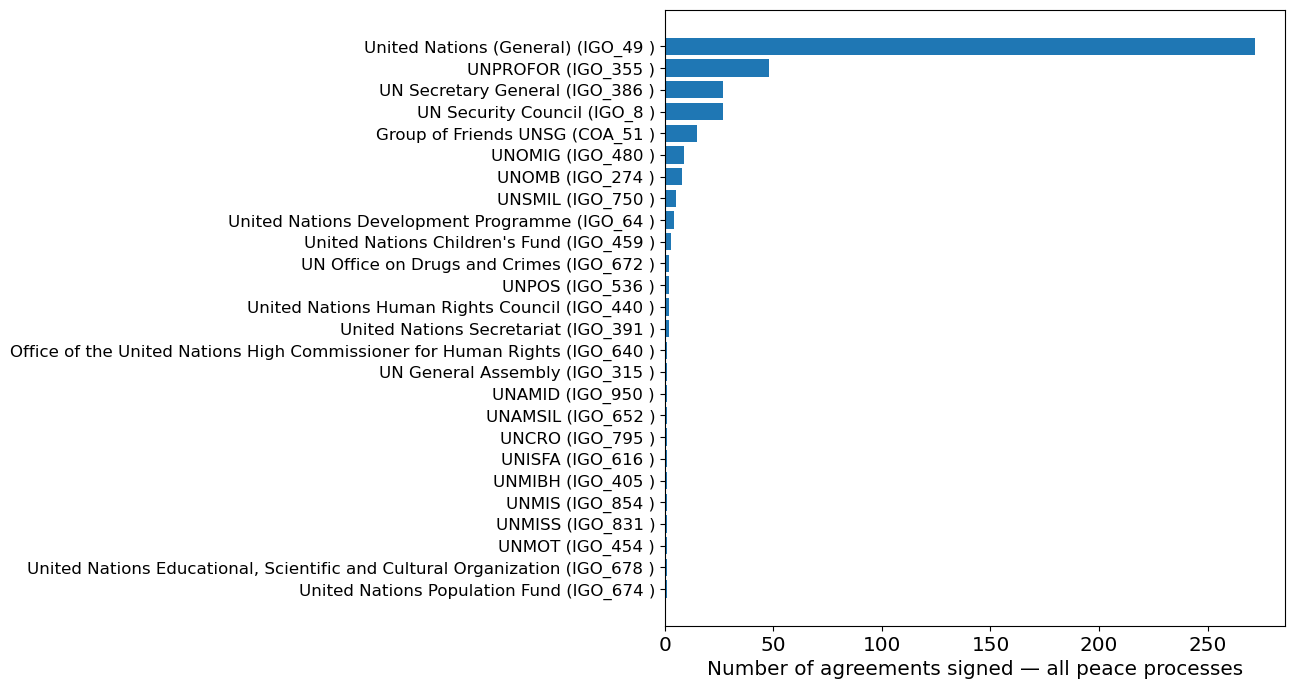

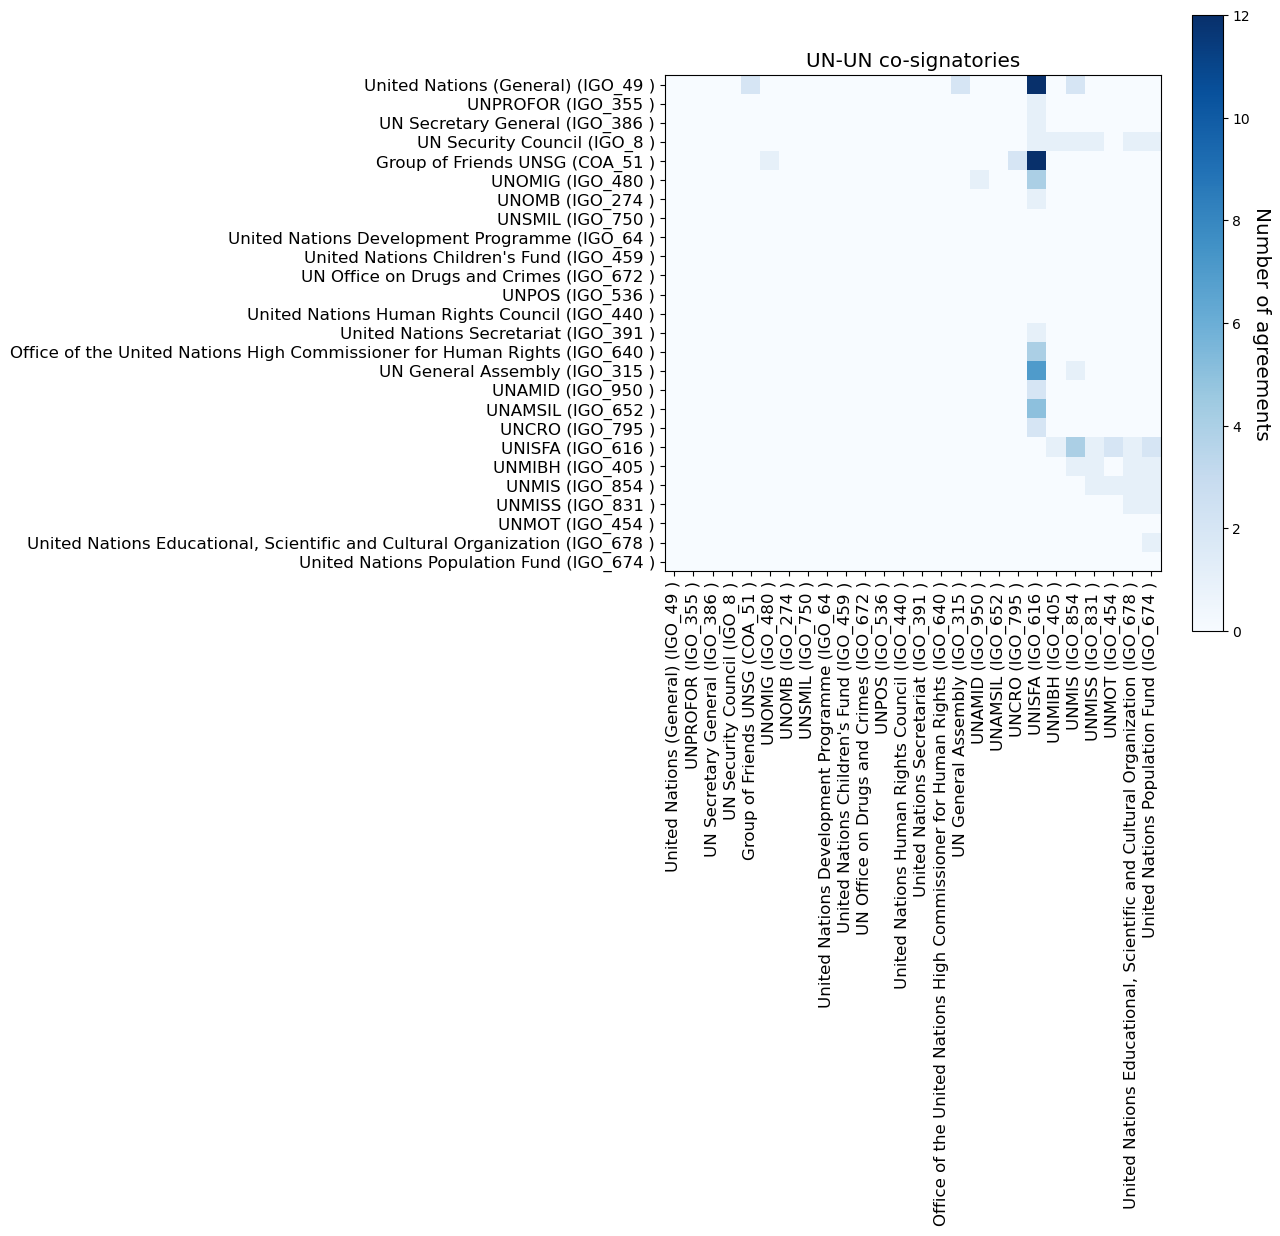

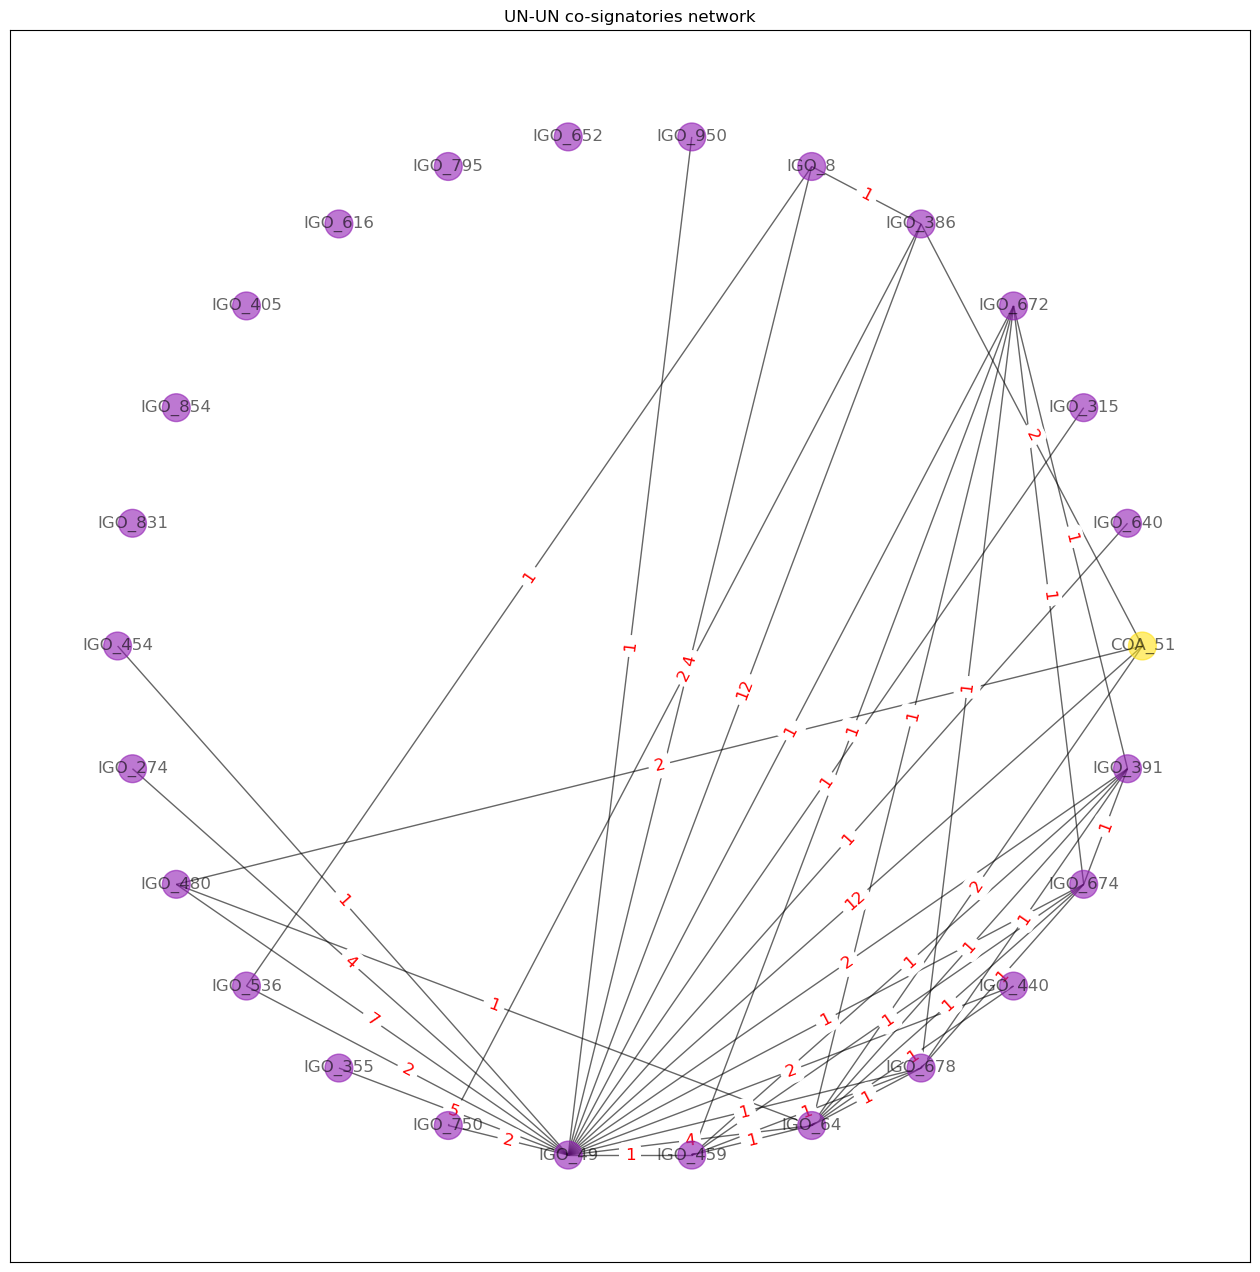

In [6]:
# Get UN actor labels

co_matrices = get_cooccurrence_matrices(un_matrix)
# Upper triangle of actor co-occurence matrix
actor_upper = np.triu(co_matrices[0],k=1)


# Co-occurrence diagonal is the columns marginal of the UN-only biadjacency matrix
diag = np.diag(co_matrices[0])
a = list(zip(diag,un_actors_list))
a = sorted(a,key=lambda t:t[0],reverse=True)
diag = [t[0] for t in a]
label_list = [t[1][2] + ' (' + t[1][1] + ' )' for t in a]

# Number of agreements signed
latex = False
if latex:
    for t in a:
        s = t[1][2] + ' & ' + '\\_'.join(t[1][1].split('_'))  + ' & ' + str(t[0]) + ' \\\\'

        #s = t[1][2] + ' & ' + str(t[0]) + ' \\\\'
        print(s)
        print('\\hline')


f = plt.figure(figsize=(8,8))
plt.barh(range(0,len(diag)),diag)
plt.yticks(range(0,len(label_list)),label_list,fontsize='large')
plt.xticks(fontsize='x-large')
plt.xlabel('Number of agreements signed — all peace processes',fontsize='x-large')
plt.gca().invert_yaxis()
plt.show()

# Heat map
f = plt.figure(figsize=(8,8))
plt.imshow(actor_upper,cmap=plt.cm.Blues)
plt.xticks(range(0,len(label_list)),label_list,rotation=90,fontsize='large')
plt.yticks(range(0,len(label_list)),label_list,fontsize='large')
cbar = plt.colorbar()
cbar.set_label('Number of agreements',rotation=270,labelpad=15,fontsize='x-large')
plt.title('UN-UN co-signatories',fontsize='x-large')
plt.show()

# Network diagram
display_comatrix_as_networkx_graph(co_matrices[0],un_indices,data_dict['actor_vertices'],data_dict,\
                                   title='UN-UN co-signatories network')

rc = np.nonzero(actor_upper) # Row and column indices of non-zero pairs
z = list(zip(list(rc[0]),list(rc[1])))
scores = [(un_actors_list[t[0]][1],un_actors_list[t[0]][2],\
           un_actors_list[t[1]][1],un_actors_list[t[1]][2],actor_upper[t[0]][t[1]]) for t in z]
scores = sorted(scores,key=lambda t:t[4],reverse=True)

# Output for LaTex document
latex = False
if latex:
    for t in scores:
        s = t[1] + ' (' + '\\_'.join(t[0].split('_')) + ') & ' +\
            t[3] + ' (' + '\\_'.join(t[2].split('_')) + ') & ' + str(t[4]) + ' \\\\'
        print(s)
        print('\\hline')

# Locate the singletons
singleton_indices = [index for index,row in enumerate(actor_upper) if np.all(row == 0) and\
                        np.all(actor_upper[:,index] == 0)]
latex = False
if latex:
    for index in singleton_indices:
        singleton_data = un_actors_list[index]
        s = singleton_data[2] + ' (' + '\\_'.join(singleton_data[1].split('_')) + ')' + ' \\\\'
        print(s)
        print('\\hline')



### Analysis: UN and non-UN co-signatories

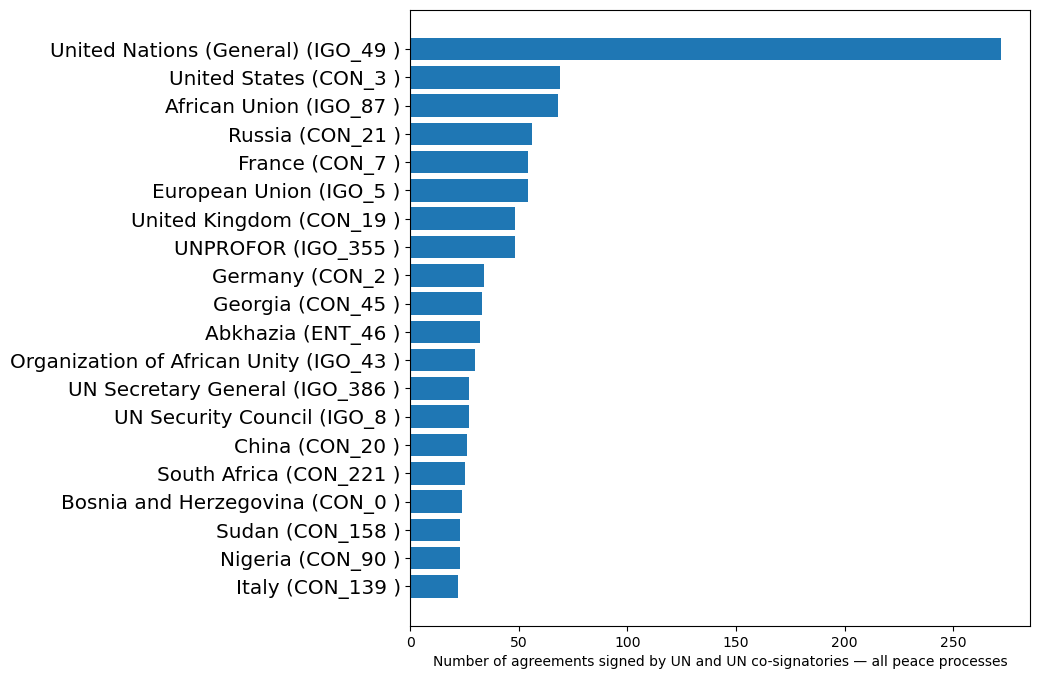

1287


In [7]:
co_matrices = get_cooccurrence_matrices(un_cosign_matrix)
actor_upper = np.triu(co_matrices[0],k=1)


un_cosign_actor_list = []
for actor_index in actor_indices:
    actor_id = data_dict['actor_vertices'][actor_index]
    actor_data = data_dict['vertices_dict'][actor_id]
    actor_name = actor_data[data_dict['nodes_header'].index('node_name')]
    un_cosign_actor_list.append((actor_index,actor_id,actor_name))

diag = np.diag(co_matrices[0])
a = list(zip(diag,un_cosign_actor_list))
a = sorted(a,key=lambda t:t[0],reverse=True)
diag = [t[0] for t in a]
label_list = [t[1][2] + ' (' + t[1][1] + ' )' for t in a[0:20]]

f = plt.figure(figsize=(8,8))
plt.barh(range(0,len(diag[0:20])),diag[0:20])
plt.yticks(range(0,len(label_list)),label_list,fontsize='x-large')
plt.xlabel('Number of agreements signed by UN and UN co-signatories — all peace processes')
plt.gca().invert_yaxis()
plt.show()

rc = np.nonzero(actor_upper) # Row and column indices of non-zero pairs
z = list(zip(list(rc[0]),list(rc[1])))
scores = [(un_cosign_actor_list[t[0]],un_cosign_actor_list[t[1]],actor_upper[t[0]][t[1]]) for t in z if\
             un_cosign_actor_list[t[0]][0] in un_indices or un_cosign_actor_list[t[1]][0] in un_indices]
scores = sorted(scores,key=lambda t:t[2],reverse=True)


print(len(scores))
latex = False
if latex:
    for t in scores[0:30]:
        a = []
        # Put UN first
        if t[0][0] in un_indices:
            a = (t[0],t[1],t[2])
        else:
            a = (t[1],t[0],t[2])
        s = a[0][2] + ' (' + '\\_'.join(a[0][1].split('_')) + ') & ' +\
        a[1][2] + ' (' + '\\_'.join(a[1][1].split('_')) + ') & ' + str(a[2]) + ' \\\\'
        print(s)
        print('\\hline')

latex = False
if latex:
    for t in scores[-15:]:
        a = []
        # Put UN first
        if t[0][0] in un_indices:
            a = (t[0],t[1],t[2])
        else:
            a = (t[1],t[0],t[2])
        s = a[0][2] + ' (' + '\\_'.join(a[0][1].split('_')) + ') & ' +\
        a[1][2] + ' (' + '\\_'.join(a[1][1].split('_')) + ') & ' + str(a[2]) + ' \\\\'
        print(s)
        print('\\hline')



## Case study: United Nations (General)

In [8]:
actor_id = 'IGO_49'
actor_index = data_dict['actor_vertices'].index(actor_id)
actor_name = get_actor_name(actor_id,data_dict)
actor_label = actor_name + ' (' + actor_id + ' )'


### Time series analysis

In [9]:
year_list = []
for i,agreement_id in enumerate(data_dict['agreement_vertices']):
    if not agreement_id in data_dict['dates_dict']:
        continue
    ag_year = int(str(data_dict['dates_dict'][agreement_id])[0:4])
    year_list.append(ag_year)
# Sort by year    
year_list = sorted(set(year_list))
print(year_list)

# Total of agreements for each year
ag_year_vector = [0]*len(year_list)
for agreement_id in data_dict['agreement_vertices']:
    year = int(str(data_dict['dates_dict'][agreement_id])[0:4])
    year_index = year_list.index(year)
    ag_year_vector[year_index] += 1
    
print(sum(ag_year_vector))


[1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
1642


#### Aggregated

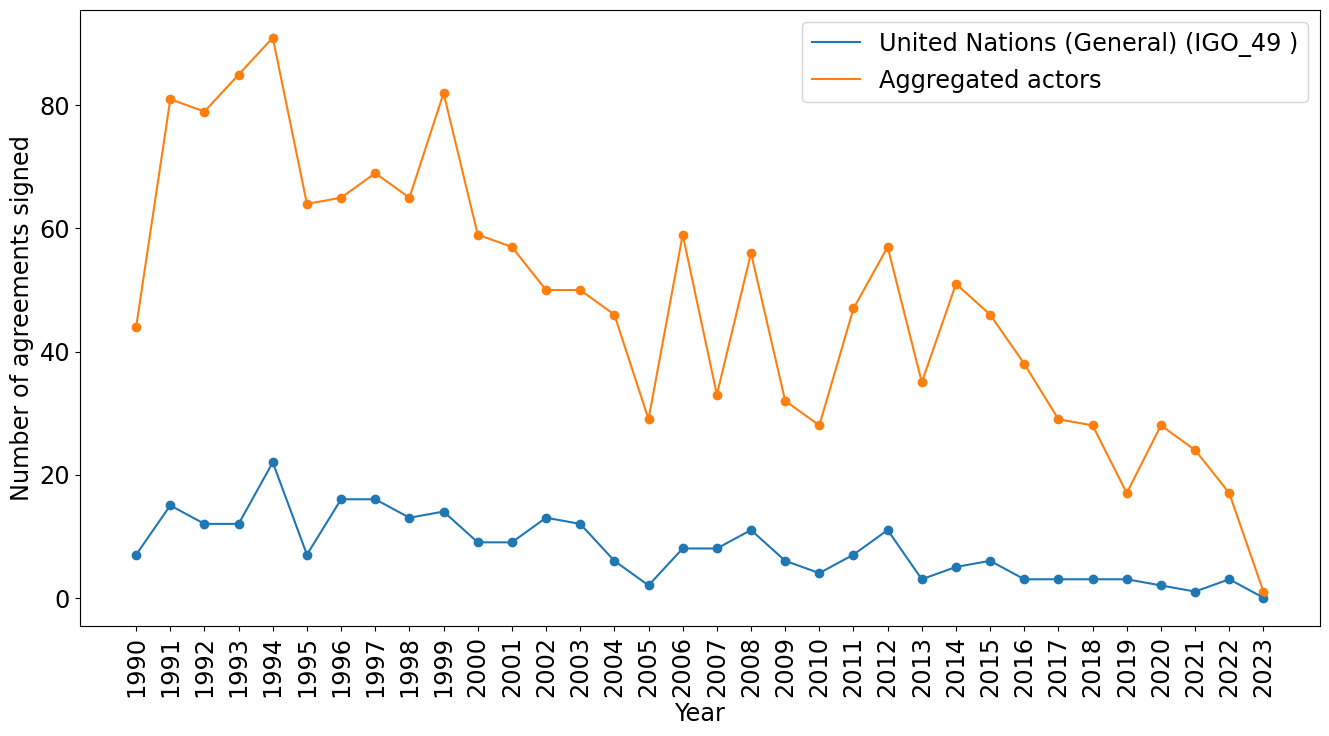

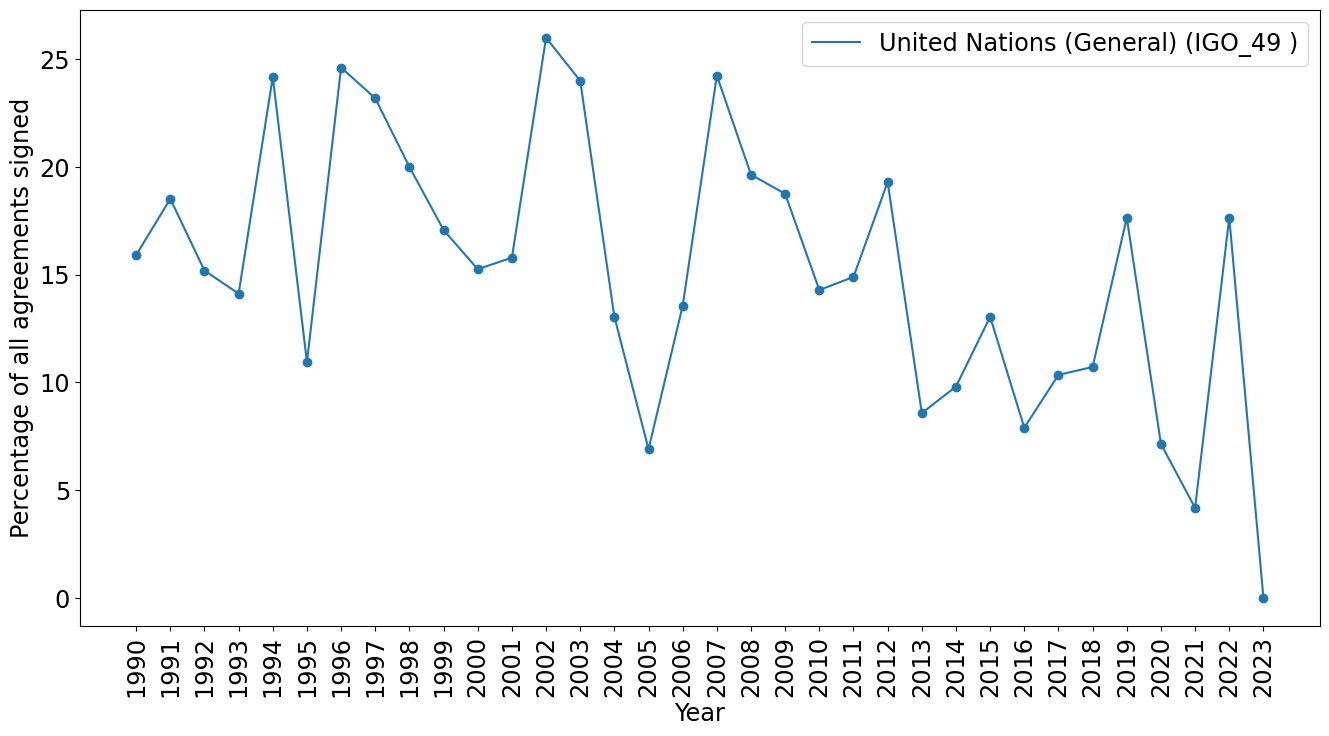


PearsonRResult(statistic=0.784435960544253, pvalue=4.027027416878897e-08)


In [10]:

year_vector = [0]*len(year_list)

# Get agreements for IGO_49
agreement_ids = [data_dict['agreement_vertices'][i] for\
                     i,v in enumerate(data_dict['matrix'][:,actor_index]) if v > 0]
#print(len(agreement_ids))

matrix_t = data_dict['matrix'].T
for j,v in enumerate(matrix_t[actor_index]):
    if v == 0:
        continue
    agreement_id = data_dict['agreement_vertices'][j]
    year = int(str(data_dict['dates_dict'][agreement_id])[0:4])
    year_index = year_list.index(year)
    year_vector[year_index] += 1

#print(len(year_vector),sum(year_vector))
#print(list(zip(year_list,ag_year_vector,year_vector)))


x = range(0,len(year_vector))

f = plt.figure(figsize=(16,8))
plt.plot(x,year_vector,label=actor_label)
plt.scatter(x,year_vector)
plt.plot(x,ag_year_vector,label='Aggregated actors')
plt.scatter(x,ag_year_vector)
plt.ylabel('Number of agreements signed',fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.xlabel('Year',fontsize='xx-large')
plt.xticks(x,year_list,rotation=90,fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.show()

# As proportion of agreements in a year
percent_vector = [round((v/ag_year_vector[i])*100,3) for i,v in enumerate(year_vector)]

f = plt.figure(figsize=(16,8))
plt.plot(x,percent_vector,label=actor_label)
plt.scatter(x,percent_vector)
plt.ylabel('Percentage of all agreements signed',fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.xlabel('Year',fontsize='xx-large')
plt.xticks(x,year_list,rotation=90,fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.show()

print()

print(stats.pearsonr(year_vector,percent_vector))


#### Get agreements in a given year

In [11]:
year = 2015

# Agreements signed by actor
agreement_ids = [data_dict['agreement_vertices'][i] for\
                     i,v in enumerate(data_dict['matrix'][:,actor_index]) if v > 0]

# Filter by year
agreements_in_year = [v for v in agreement_ids if int(str(data_dict['dates_dict'][v])[0:4])==year]

latex = False
if latex:
    for agreement_id in agreements_in_year:
        agreement_name = get_agreement_name(agreement_id,data_dict)
        s = '\\_'.join(agreement_id.split('_'))  + ' & ' + agreement_name + ' \\\\'
        print(s)
        print('\\hline')
    

In [12]:
co_matrices = get_cooccurrence_matrices(data_dict['matrix'])
cosign_ids = [data_dict['actor_vertices'][i] for i,v in enumerate(co_matrices[0][actor_index]) if v > 0]

agreement_cosign_dict = {}
for cosign_id in cosign_ids:
    agreements = get_consignatory_agreements_from_data_dict([actor_id,cosign_id],data_dict)
    for agreement_id in agreements:
        if int(str(data_dict['dates_dict'][agreement_id])[0:4]) != year:
            continue
        if agreement_id in agreement_cosign_dict:
            agreement_cosign_dict[agreement_id].append((cosign_id,get_actor_name(cosign_id,data_dict)))
        else:
            agreement_cosign_dict[agreement_id] = [(cosign_id,get_actor_name(cosign_id,data_dict))]

latex = False
if latex:
    for agreement_id,actors in agreement_cosign_dict.items():
        agreement_name = get_agreement_name(agreement_id,data_dict)
        actors = sorted(actors,key=lambda t:t[1])
            
        s = '\\_'.join(agreement_id.split('_'))  + ' & ' + agreement_name +\
        ' & ' + ', '.join([t[1] for t in actors]) +  ' \\\\'
        print(s)
        print('\\hline')


### Metadata analysis

#### Peace processes

152
57
272


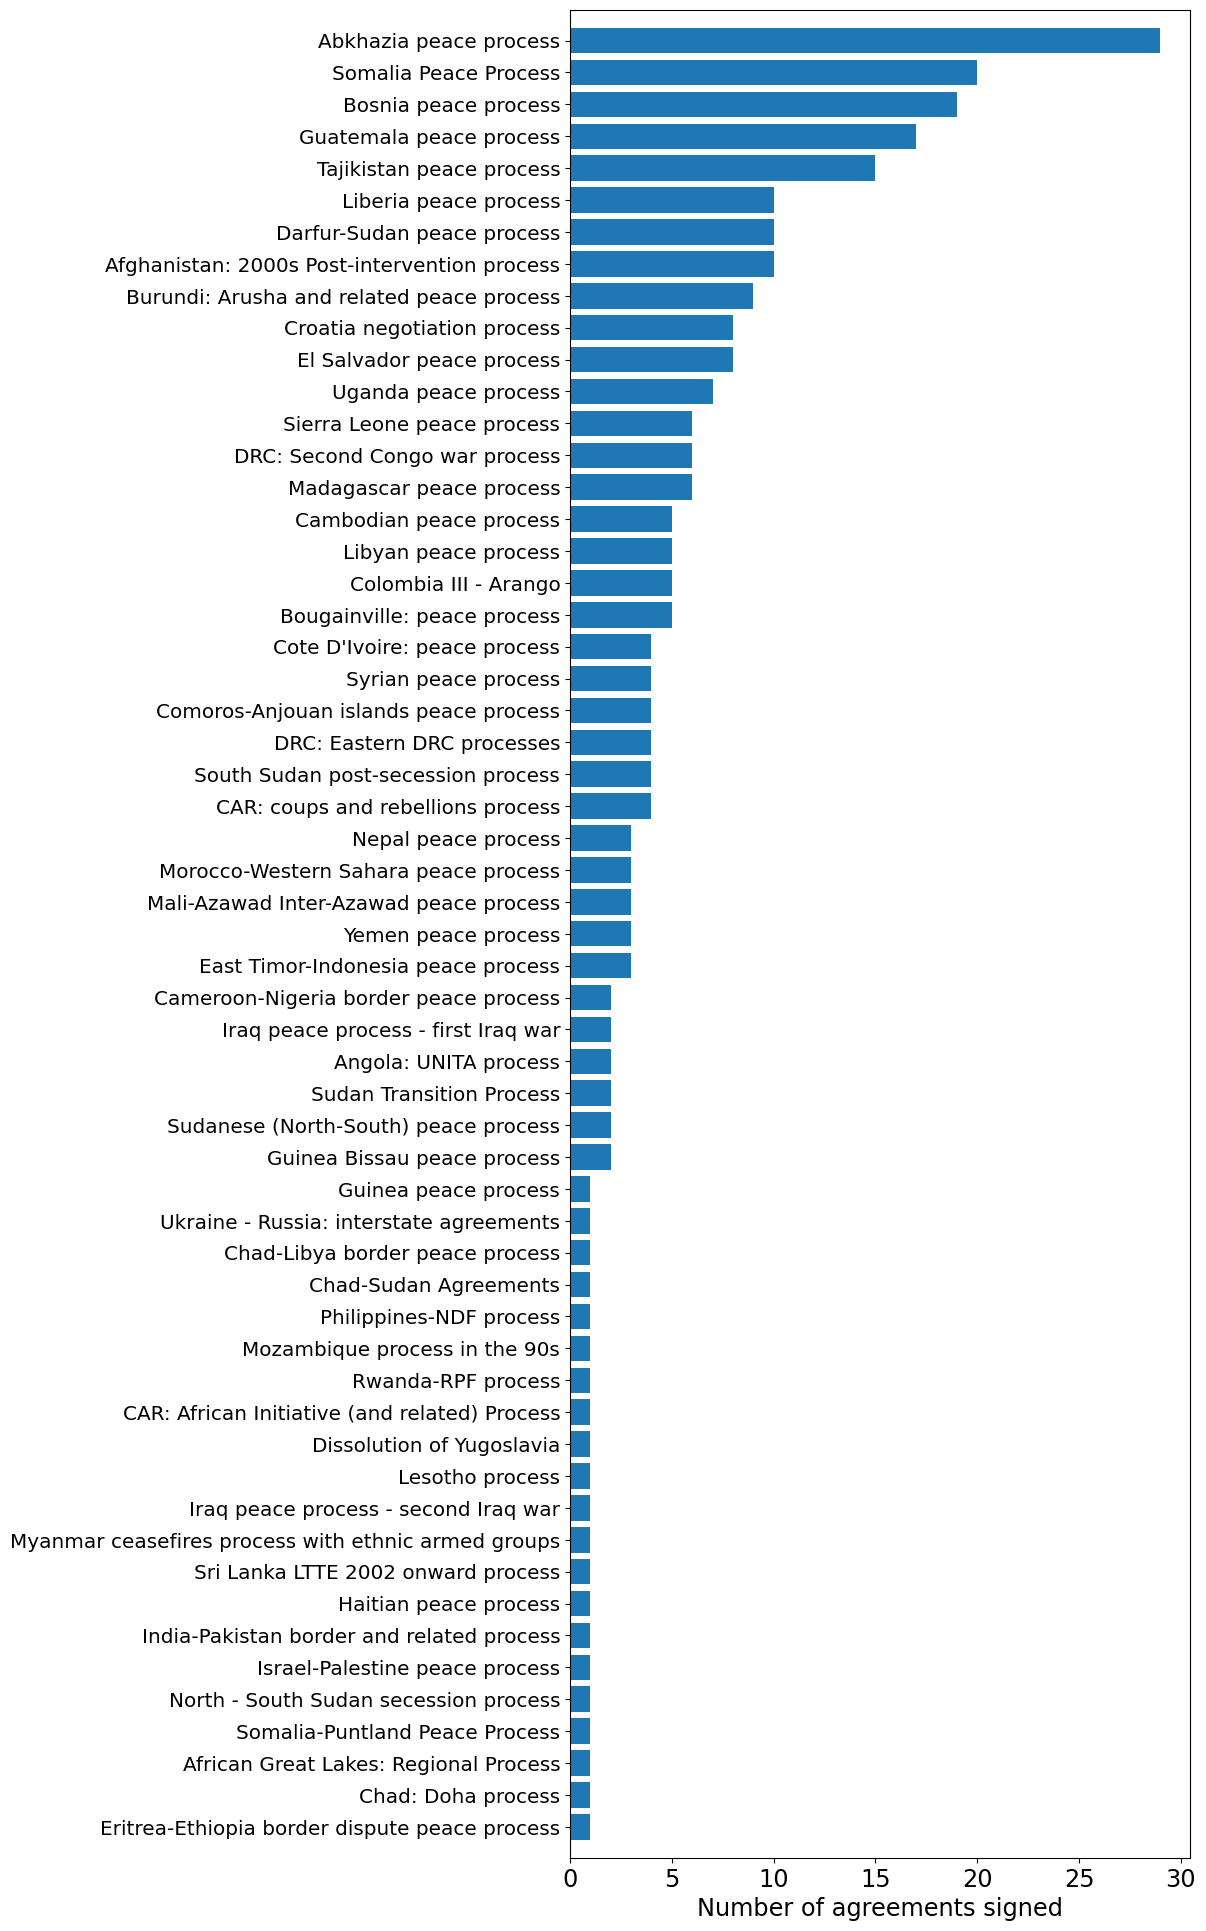

In [13]:

# All agreements signed by selected actor
agreement_ids = [data_dict['agreement_vertices'][i] for\
                     i,v in enumerate(data_dict['matrix'][:,actor_index]) if v > 0]


all_processes = get_peace_processes(data_dict)
print(len(all_processes))

actor_processes = {}
for agreement_id in agreement_ids:
    process = data_dict['vertices_dict'][agreement_id][data_dict['nodes_header'].index('PPName')].strip()
    if process in actor_processes:
        actor_processes[process].append(agreement_id)
    else:
        actor_processes[process] = [agreement_id]
        
print(len(actor_processes))    
print(sum([len(v) for k,v in actor_processes.items()]))

actor_processes = sorted(actor_processes.items(),key=lambda kv:len(kv[1]))

f = plt.figure(figsize=(8,24))
y = [len(t[1]) for t in actor_processes]
x = range(0,len(y))
plt.barh(x,y)
plt.xlabel('Number of agreements signed',fontsize='xx-large')
plt.xticks(fontsize='xx-large')
plt.yticks(x,[t[0] for t in actor_processes],fontsize='x-large')
plt.margins(y=0.01)
plt.show()


#### Agreement stage analysis

272


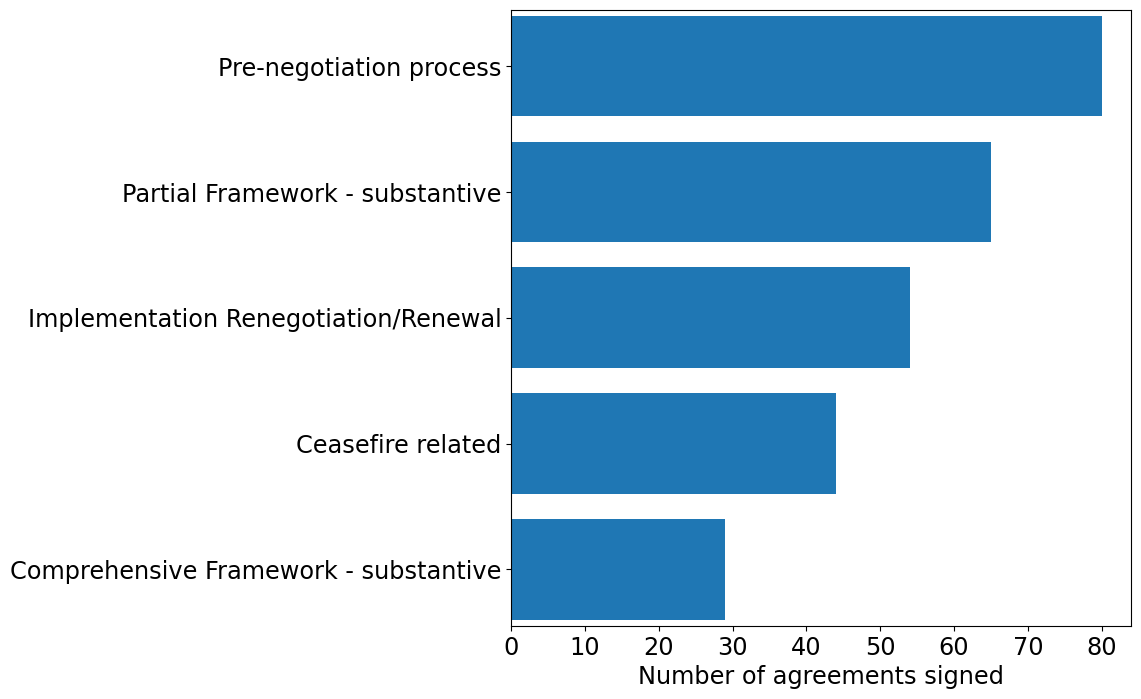

(5, 34)
['Comprehensive Framework - substantive', 'Ceasefire related', 'Implementation Renegotiation/Renewal', 'Partial Framework - substantive', 'Pre-negotiation process']


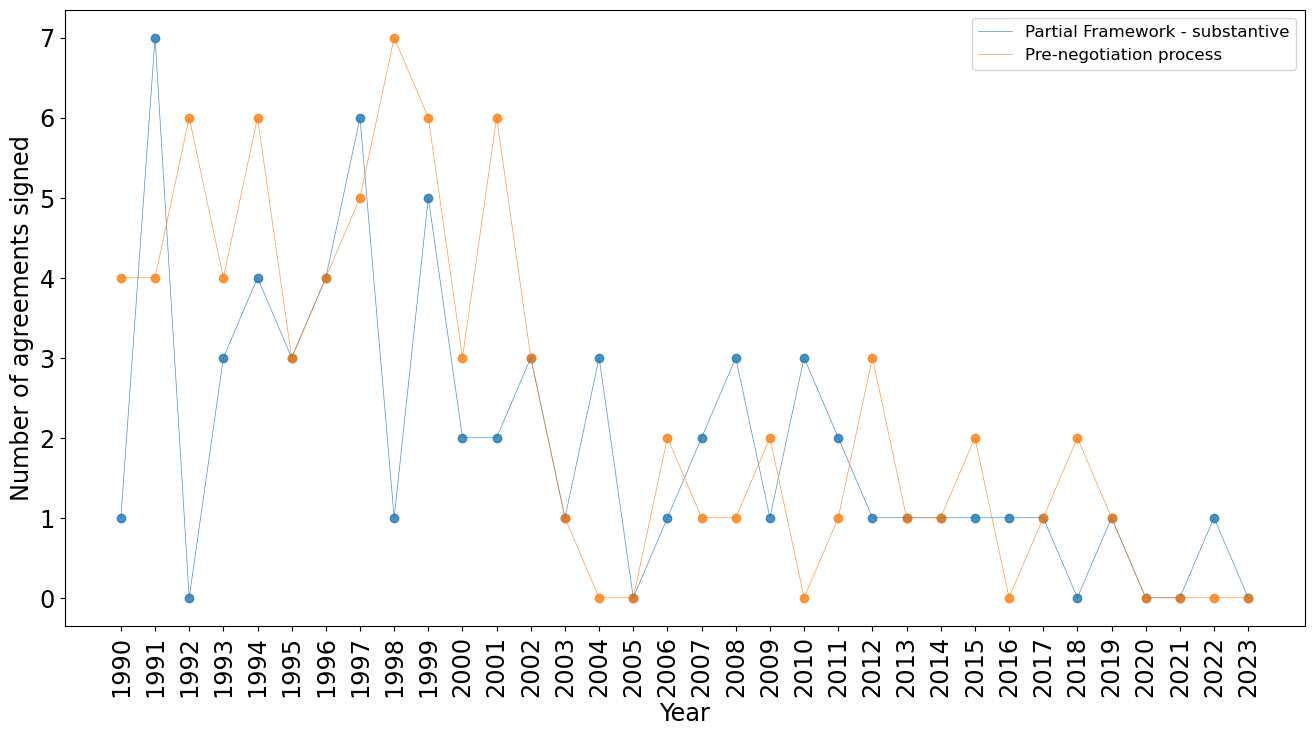

PearsonRResult(statistic=0.44239251159898246, pvalue=0.008797718265661648)


In [59]:
# All agreements signed by selected actor
agreement_ids = [data_dict['agreement_vertices'][i] for\
                     i,v in enumerate(data_dict['matrix'][:,actor_index]) if v > 0]

stage_dict = {}
stage_dict['Cea'] = [1,'Ceasefire related']
stage_dict['Pre'] = [2,'Pre-negotiation process']
stage_dict['SubPar'] = [3,'Partial Framework - substantive']
stage_dict['SubComp'] = [4,'Comprehensive Framework - substantive']
stage_dict['Ren'] = [5,'Implementation Renegotiation/Renewal']
stage_dict['Imp'] = [5,'Implementation Renegotiation/Renewal']
stage_dict['Oth'] = [0,'']

# Map selected actor agreements on to stages
stage_map = {}
for agreement_id in agreement_ids:
    pax_id = agreement_id.split('_')[1]
    agreement_year = int(str(data_dict['dates_dict'][agreement_id])[0:4])
    if pax_id in data_dict['agreements_dict']:
        # Can't get stage so put in other
        stage_id = stage_dict[data_dict['agreements_dict'][pax_id]['Stage']][1]
        if stage_id in stage_map:
            stage_map[stage_id].append((agreement_id, agreement_year))
        else:
            stage_map[stage_id] = [(agreement_id, agreement_year)]
    else:
        # Can't get stage so put in other
        if 0 in stage_map:
            stage_map[0].append((agreement_id, agreement_year))
        else:
            stage_map[0] = [(agreement_id, agreement_year)]
            
print(sum([len(v) for k,v in stage_map.items()]))

stage_map = sorted(stage_map.items(),key=lambda kv:len(kv[1]))
stage_labels = [t[0] for t in stage_map]

f = plt.figure(figsize=(8,8))
y = [len(t[1]) for t in stage_map]
x = range(0,len(y))
plt.barh(x,y)
plt.xlabel('Number of agreements signed',fontsize='xx-large')
plt.xticks(fontsize='xx-large')
plt.yticks(x,stage_labels,fontsize='xx-large')
plt.margins(y=0.01)
plt.show()


# Stage analysis by year - build a stage map year matrix
stage_matrix = np.zeros((len(stage_map),len(year_list)))
print(stage_matrix.shape)
for i,stage_data in enumerate(stage_map):
    for ag_data in stage_data[1]:
        stage_matrix[i][year_list.index(ag_data[1])] += 1


x = range(0,stage_matrix.shape[1])

print(stage_labels)

f = plt.figure(figsize=(16,8))
for i,row in enumerate(stage_matrix):
    if not i in [3,4]:
        continue
    plt.plot(x,row,label=stage_labels[i],linewidth=0.5,alpha=0.8)
    plt.scatter(x,row,alpha=0.8)
plt.ylabel('Number of agreements signed',fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.xlabel('Year',fontsize='xx-large')
plt.xticks(x,year_list,rotation=90,fontsize='xx-large')
plt.legend(fontsize='large')
plt.show()

print(stats.pearsonr(stage_matrix[3],stage_matrix[4]))


#### Region analysis

272


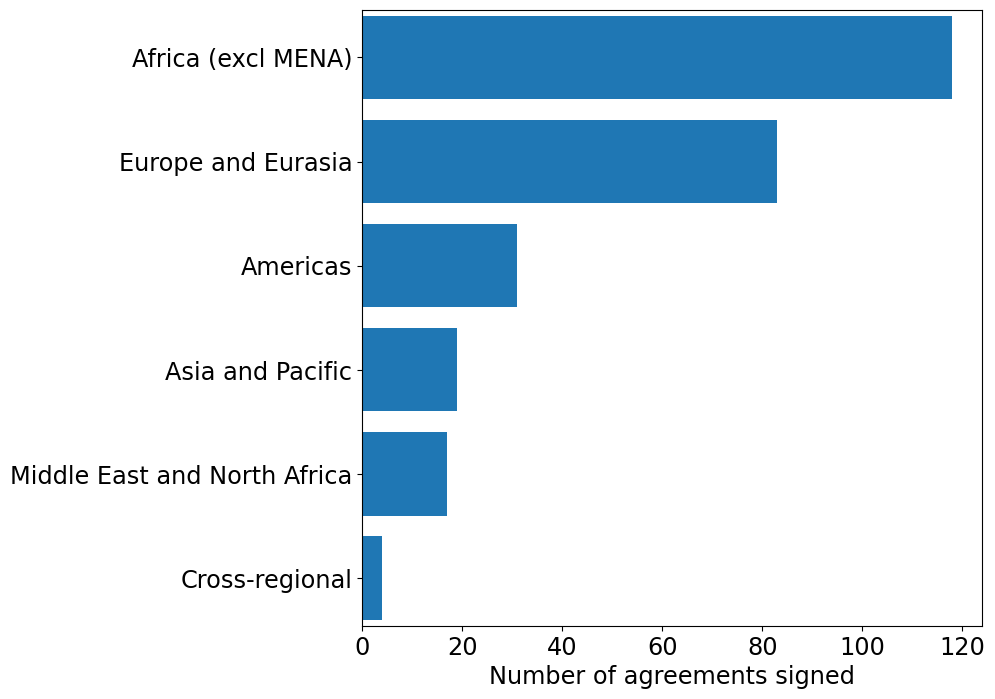

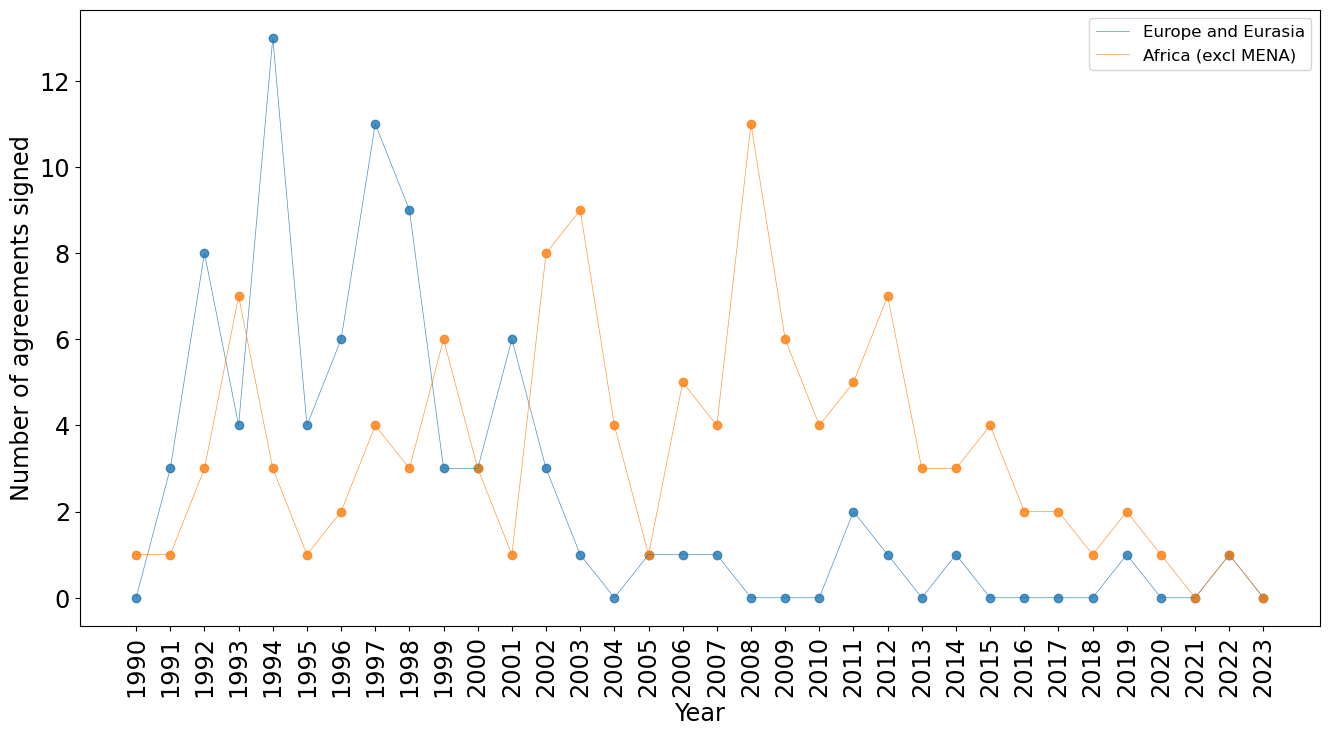

PearsonRResult(statistic=-0.026843907820797763, pvalue=0.8802141334477069)


In [56]:
# All agreements signed by selected actor
agreement_ids = [data_dict['agreement_vertices'][i] for\
                     i,v in enumerate(data_dict['matrix'][:,actor_index]) if v > 0]

# Map selected actor agreements on to regions
region_map = {}
for agreement_id in agreement_ids:
    agreement_year = int(str(data_dict['dates_dict'][agreement_id])[0:4])
    pax_id = agreement_id.split('_')[1]
    if pax_id in data_dict['agreements_dict']:
        # Can't get stage so put in other
        region = data_dict['agreements_dict'][pax_id]['Region']
        if region in region_map:
            region_map[region].append((agreement_id, agreement_year))
        else:
            region_map[region] = [(agreement_id, agreement_year)]
    else:
        # Can't get region so put in other
        if 'Unknown' in region_map:
            region_map['Unknown'].append((agreement_id, agreement_year))
        else:
            region_map['Unknown'] = [(agreement_id, agreement_year)]

print(sum([len(v) for k,v in region_map.items()]))

region_map = sorted(region_map.items(),key=lambda kv:len(kv[1]))
region_labels = [t[0] for t in region_map]

f = plt.figure(figsize=(8,8))
y = [len(t[1]) for t in region_map]
x = range(0,len(y))
plt.barh(x,y)
plt.xlabel('Number of agreements signed',fontsize='xx-large')
plt.xticks(fontsize='xx-large')
plt.yticks(x,region_labels,fontsize='xx-large')
plt.margins(y=0.01)
plt.show()


# Region analysis by year - build a stage map year matrix
region_matrix = np.zeros((len(region_map),len(year_list)))
for i,region_data in enumerate(region_map):
    for ag_data in region_data[1]:
        region_matrix[i][year_list.index(ag_data[1])] += 1
        
x = range(0,region_matrix.shape[1])

f = plt.figure(figsize=(16,8))
for i,row in enumerate(region_matrix):
    if not i in [4,5]:
        continue
    plt.plot(x,row,label=region_labels[i],linewidth=0.5,alpha=0.8)
    plt.scatter(x,row,alpha=0.8)
plt.ylabel('Number of agreements signed',fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.xlabel('Year',fontsize='xx-large')
plt.xticks(x,year_list,rotation=90,fontsize='xx-large')
plt.legend(fontsize='large')
plt.show()

print(stats.pearsonr(region_matrix[4],region_matrix[5]))


#### Region-stage analysis

Build a stage-region matrix with cells containing the number of agreements for a stage-region pair.


(5, 6)
272


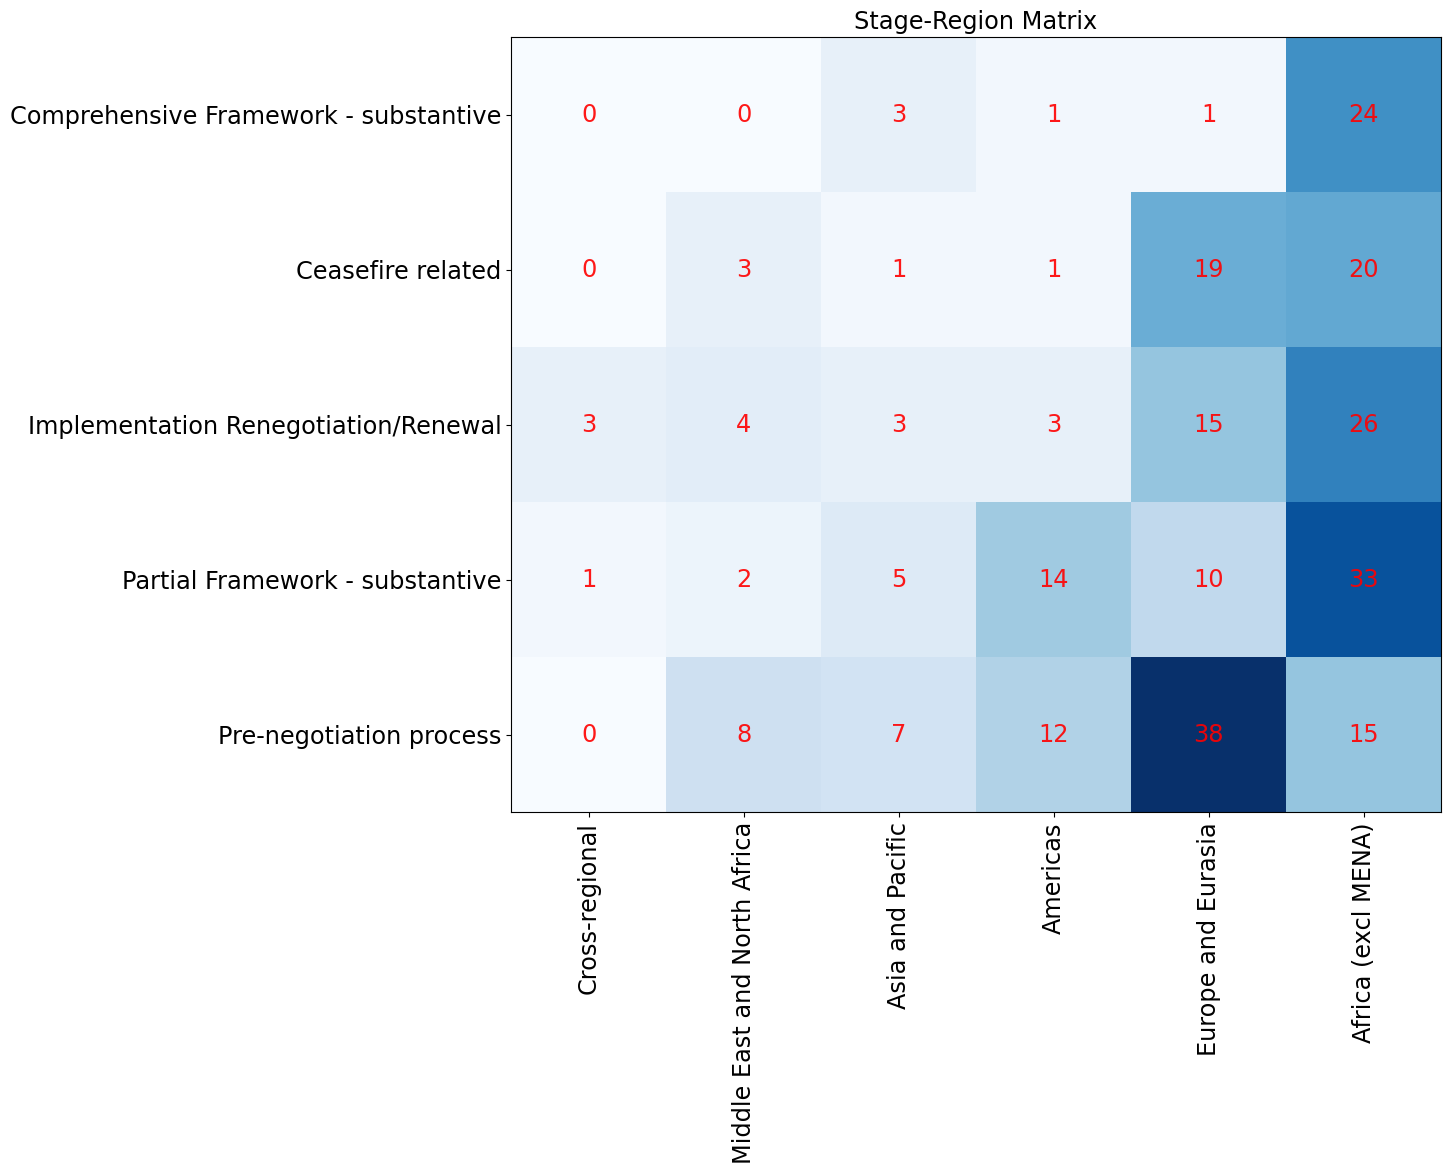

In [16]:
stage_list = [t[0] for t in stage_map]
region_list = [t[0] for t in region_map]

sr_matrix = np.zeros((len(stage_map),len(region_map))).astype(int)

print(sr_matrix.shape)

agreement_ids = [data_dict['agreement_vertices'][i] for\
                     i,v in enumerate(data_dict['matrix'][:,actor_index]) if v > 0]

for agreement_id in agreement_ids:
    pax_id = agreement_id.split('_')[1]
    if pax_id in data_dict['agreements_dict']:
        stage = stage_dict[data_dict['agreements_dict'][pax_id]['Stage']][1]
        stage_index = stage_list.index(stage)
        region = data_dict['agreements_dict'][pax_id]['Region']
        region_index = region_list.index(region)
        sr_matrix[stage_index][region_index] += 1

print(sum([v for row in sr_matrix for v in row]))
# Heat map
f = plt.figure(figsize=(12,12))
plt.imshow(sr_matrix,cmap=plt.cm.Blues)
plt.yticks(range(0,len(stage_list)),stage_list,fontsize='xx-large')
plt.xticks(range(0,len(region_list)),region_list,rotation=90,fontsize='xx-large')
#cbar = plt.colorbar()
#cbar.set_label('Number of agreements',rotation=270,labelpad=15,fontsize='xx-large')
plt.title('Stage-Region Matrix',fontsize='xx-large')
for (j,i),value in np.ndenumerate(sr_matrix):
    plt.text(i,j,value,ha='center',va='center',color='red',fontsize='xx-large',alpha=0.9)
plt.show()
